In [58]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

import os
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



## 0. Util functions

In [38]:
INPUT_DIR = '/Users/G_bgyl/si699/Rushhour/raw_data/sf_speed_data/test_data_2016/'

In [43]:
# Specifiy directory containing shape file
GIS_DATA_DIR = '../raw_data/census_zones/sf/'
SHP_FILE = 'geo_export_8c14e8b6-2d3c-4109-af6b-f6e25cb69f0c.shp'
SF_CENSUS_ZONES = gpd.GeoDataFrame.from_file(GIS_DATA_DIR + SHP_FILE)
print('Size of census zones df: {}'.format(SF_CENSUS_ZONES.shape))
SF_CENSUS_ZONES.head()

Size of census zones df: (197, 13)


,aland10,awater10,countyfp10,funcstat10,geoid10,intptlat10,intptlon10,mtfcc10,name10,namelsad10,statefp10,tractce10,geometry
0,370459.0,0.0,075,S,06075016500,+37.7741958,-122.4477884,G5020,165,Census Tract 165,06,016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,309097.0,0.0,075,S,06075016400,+37.7750995,-122.4369729,G5020,164,Census Tract 164,06,016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,245867.0,0.0,075,S,06075016300,+37.7760456,-122.4295509,G5020,163,Census Tract 163,06,016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,368901.0,0.0,075,S,06075016100,+37.7799831,-122.4286631,G5020,161,Census Tract 161,06,016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,158236.0,0.0,075,S,06075016000,+37.7823363,-122.4224838,G5020,160,Census Tract 160,06,016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [44]:
def file_cleaner(data_intput, data_output, file_name):
    '''Reads in SF speed data and formats them into proper csv files'''
    
    with open(data_intput + file_name, 'r') as old_file:
        with open(data_output + file_name, 'w') as new_file:
            first = 0 
            for line in old_file.readlines():
                # If it is the first line, separate the header from the data
                if first == 0: 
                    line = re.sub(r'\t|\n|\s+', '', line)
                    header = re.findall(r'[A-Z+?\_?]+', line)
                    data = re.findall(r'[\-?\d+?\/?\.?\:?]+|\,(?=\,)', line)
                    
                    # Date and time are connected 
                    date = re.search(r'(\d{2}\/){2}\d{4}', data[1]).group(0)
                    time = re.search(r'(\d{2}\:){2}\d{2}', data[1]).group(0)
                    date = date + ' ' + time 
                    
                    # Remove the merged date and time
                    data.remove(data[1])
                    
                    # Insert separated date and time
                    data.insert(1, date)
                    
                    data = [x if x != ',' else '' for x in data]
                    header = (',').join(header)
                    data = (',').join(data)
                    new_file.write(header + '\n')
                    new_file.write(data + '\n')
                    first += 1 
                else:
                    if line != '\n':
                        line = line.rstrip()
                        new_file.write(line + '\n')

In [61]:
def mapping_function(traffic_df):
    """Convert pandas to geopandas, and return a df with information of region mapping id
    
    """
    # Convert pandas to geopandas
    geom = traffic_df.apply(lambda x: Point(x['LONGITUDE'], x['LATITUDE']), axis=1)
    traffic = gpd.GeoDataFrame(traffic_df, geometry=geom)
    # traffic.crs = {'init': 'epsg:4326'}
    print('Size of travel speed data: {}'.format(traffic.shape))


    # Join with census data
    # 'op' - operation | specify 'within' because we want our zip points 
    # that are within state polygons. 
    SF_CENSUS_ZONES.crs = traffic.crs
    mapped_traffic = gpd.sjoin(traffic, SF_CENSUS_ZONES, op='within')

    return mapped_traffic

In [46]:
def get_fname(path,contains = '2016'):
    # get file name for all subfiles for the whole ukwac corpus.
    file = [f for f in os.listdir(path) if re.search('(.+\.csv$)', f)]
    if contains:
        file = [f for f in file if contains in f]
    file = sorted(file)
    return file

In [47]:
def convert_date(df, columns=['REPORT_TIME'],time_range = False):
    
    """ # input: 
        df: original dataframe. 
        columns: represent names of columns that was time type.
        change_index: True for audio and activity data, False for conversation data
        # output: dataframe. Turn timestamp from unix time into readable time. and set index and change time zone.
    """
    print('begin convert date')
    for col in columns:
#         df[col] = pd.to_datetime(df[col],unit='s',utc=True).dt.tz_convert('US/Eastern') # .dt.tz_localize('US/Eastern')
        df[col] = pd.to_datetime(df[col])
        print('begin change index in convert_date')
        if not time_range:
            #there is only on timestamp column, so use it as index
            df.index =  pd.to_datetime(df[col]) # .dt.date
    print('finish convert date')
    return df

In [51]:
def create_time_df(path, columns=['REPORT_TIME'],Y = 'SPEED',unit = 'H',aggregate_func = np.mean):
    """take a directory of user files into a frequency level time series.(mean)
    Actually it now returns a pandas series, which is the input of 'def predict_time_series_ARIMA function()'
    
    Inputs:
    path: the output file dir of 'def aggregate_to_region()'
    columns: the list column name string that need to convert to date
    Y: a string of one column that need to be treated as Y
    unit: time granularity. eg, 'H'
    aggregate_func: a function name, specifies how to aggragate data points.
    
    Output:
    new_time_df.iloc[0]: a pandas series with time as index, 
                         mean(or other aggregate_func()) speed within one hour(or other time granularity) as data.
    """
    print('begin create_time_df')
    f_names = get_fname(path)
    new_time_df = pd.DataFrame()

    for user_f in f_names:

        data_user = pd.read_csv(path+user_f)
        df_user = convert_date(data_user,columns=columns)
        
        # select the column that is the Y 
        col_inf = [i for i in df_user.columns if Y in i][0]

        
        
        # group second data into days.
        weekly = df_user[col_inf].resample(unit).aggregate_func()
        # weekly.plot(style = [':','--','-'])


        # turn a series of data into a row(with dataframe type).
        weekly_transposed = weekly.to_frame(name=user_f.strip('.csv')).transpose()

        # add into final result
        new_time_df = pd.concat([new_time_df,weekly_transposed])
    print('finish create_time_df')
    return new_time_df.iloc[0]

In [6]:
# tmp_df = pd.read_csv('../raw_data/sf_speed_data/test_data_2016/sfmtaAVLRawData01032016.csv')
# group_tmp_df = tmp_df.groupby('REV')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# tmp_df.columns

Index(['REV', 'REPORT_TIME', 'VEHICLE_TAG', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'HEADING', 'TRAIN_ASSIGNMENT', 'PREDICTABLE1506', '01/03/2016 00:03:29',
       '01', '-122.42047', '37.80633', '0.0', '201.0', 'Unnamed: 15', '0'],
      dtype='object')

In [35]:
# i=0
# for region_id, group in group_tmp_df:
#     for raw_id, raw in group.iterrows():
#         print(','.join([str(cell) for cell in list(raw)]))
#         break

1506,01/03/2016 00:04:59,1,-122.42048999999999,37.80638,0.0,256.0,nan,0,nan,nan,nan,nan,nan,nan,nan,nan


In [70]:
def generate_fname_wPath(DIR, region_id, attr =False):
    """Generate file name with whole path
    """
#     # avoid file name with "'"
#     if "'" in attr:
#         attr = attr.replace("'", "_")
    fname_wPath = '%s/%s_%s.csv'%(DIR,attr,region_id)
    return fname_wPath

    

In [68]:
def aggregate_to_region(input_path,output_path):
    """ this function take a directory of time series data and target output directory string as input, 
    get region-based csv file as a preparation for prediction function later.
    for now, this function is based on the output from 'def mapping_function()'
    only need to run once for data preparation.
    
    input: 
    input_path: a string of the path of input, contains one csv file for each day. 
                eg:'../output/sf_speed_data_clean/'
    output_path: a string of the path of output, will contains one csv file for each region
                eg:'../output/sf_speed_data_region/'
    
    output: 
    write files to output_path
    """
    out_file_attr = 'time_series_region'
    f_names = get_fname(input_path,contains = '2016')
    # make sure whether the output dir exists or not.
    if os.path.isdir(output_path):
        pass
    else:
        Print('Creating new directory...')
        command = 'mkdir {}'.format(output_path)
        os.system(command)
    
    for fname in f_names:
        day_file = pd.read_csv(input_path+fname)
        
        # loop though data for each region and open only one region file each time to save memory
        for region_id, group_df in day_file.groupby('geoid10'):# TODO: may need to change column name
            # make sure whether the region file has already exist
            out_fname = generate_fname_wPath(output_path, attr = out_file_attr,region_id = region_id)
            if os.path.exists(out_fname):
                f = open(out_fname,'a')
            else:
                f = open(out_fname,'w+')
                f.write(','.join(day_file.columns)+'\n')
                
            for _, rows in group_df.iterrows():
                f.write(','.join([str(cell) for cell in list(rows)])+'\n')
                
            f.close()
        print('finished %s'%(fname))
    

In [55]:
# from code snippet: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def predict_time_series_ARIMA(mean_series,title,fig_size,split_size = 0.9,full=False):
    
    labels = mean_series.index # add label
    X = mean_series.values
    size = int(len(X) * split_size)

    train, test = X[0:size], X[size:len(X)]
    
    test_label =labels[size:len(labels)]# add label
    history = [x for x in train]
    predictions = list()
    indexes = list()# add label
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        indexes .append(test_label[t])# add label
#         if t %100 ==0:
#             print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    sns.set(rc={'figure.figsize':fig_size})
    if full:
        plt.plot(labels,X)
#         plt.plot(labels[int(len(labels)/2):],X[int(len(X)/2):])
    else:
        plt.plot(indexes,test)
    plt.plot(indexes,predictions, color='red')#
    plt.legend()
    plt.title(title)
    
    return plt

## 1. read in data

### 1.1 clean file format

In [56]:
# clean files
DIR_ROOT = '/Users/G_bgyl/si699/Rushhour/'
data_dir =DIR_ROOT + '/raw_data/sf_speed_data/test_data_2016/'
data_output = DIR_ROOT +'/output/sf_speed_data_clean/'
file_list = get_fname(data_dir)
for fname in file_list:
    file_cleaner(data_dir,data_output,fname)

### 1.2 conduct mapping function

In [62]:
mapping_dir = data_output
map_fnames = get_fname(mapping_dir)

for fname in map_fnames:
    traffic_df = pd.read_csv(mapping_dir+fname)
    df_mapped = mapping_function(traffic_df)
    df_mapped.to_csv(mapping_dir+fname, index = False)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Size of travel speed data: (494778, 10)
Size of travel speed data: (684534, 10)
Size of travel speed data: (306597, 10)
Size of travel speed data: (304830, 10)
Size of travel speed data: (308470, 10)
Size of travel speed data: (310483, 10)
Size of travel speed data: (266889, 10)


### 1.3 group data into regions

In [69]:
group_input_dir = mapping_dir
group_output_dir = DIR_ROOT+'/output/sfmta_regions/'
aggregate_to_region(group_input_dir,group_output_dir)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075022902.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075022903.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075980501.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075980600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075980900.csv
finished sfmtaAVLRawData01032016.csv


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025401.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075990100.csv
finished sfmtaAVLRawData01042016.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si6

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025401.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

finished sfmtaAVLRawData01052016.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si6

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025401.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

finished sfmtaAVLRawData01062016.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si6

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025401.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075990100.csv
finished sfmtaAVLRawData01072016.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si6

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025401.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

finished sfmtaAVLRawData01082016.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010500.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010600.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010700.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010800.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075010900.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011000.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075011100.csv
/Users/G_bgyl/si6

/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023001.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023003.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023102.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023103.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075023400.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025100.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025200.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025300.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//time_series_region_6075025401.csv
/Users/G_bgyl/si699/Rushhour//output/sfmta_regions//ti

finished sfmtaAVLRawData01092016.csv


In [45]:
sample_time_series = create_time_df(data_output)

begin create_time_df


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


begin convert date
begin change index in convert_date
finish convert date
finish create_time_df


### plot out ARIMA

No handles with labels found to put in legend.


Test MSE: 0.620


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

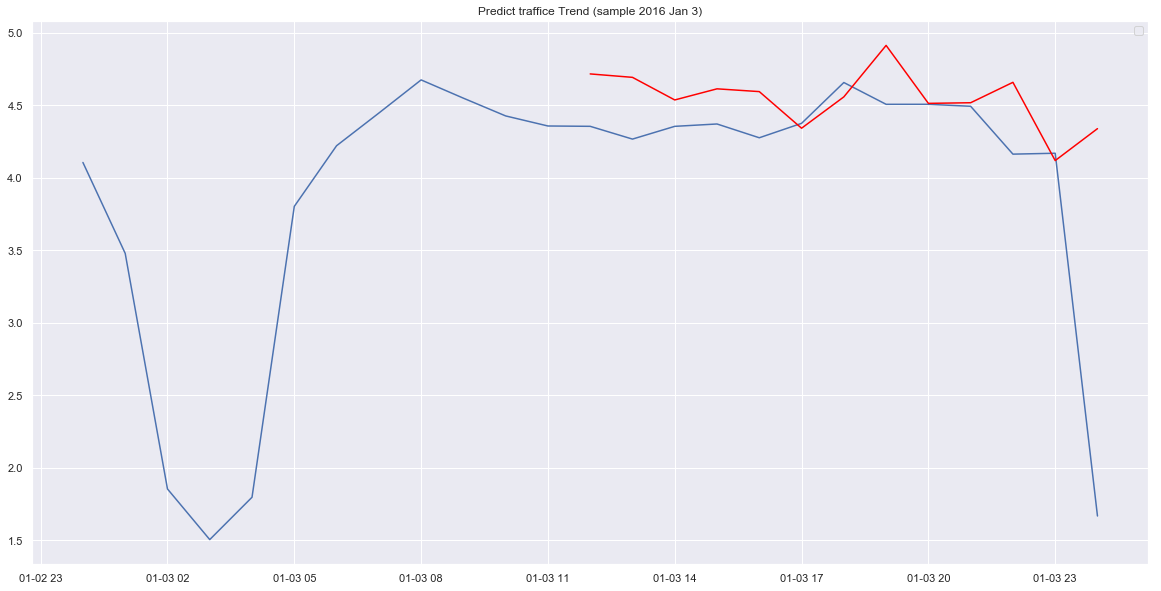

In [72]:
predict_time_series_ARIMA(sample_time_series.iloc[0],title = 'Predict traffice Trend (sample 2016 Jan 3)',fig_size = (20,10),split_size = 0.5,full = True)

In [32]:
pd.read_csv(data_output+fname).head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,HEADING,TRAIN_ASSIGNMENT,PREDICTABLE
0,1506,01/03/2016 00:03:29,1,-122.42047,37.80633,0.0,201.0,NaN,0
1,1506,01/03/2016 00:04:59,1,-122.42049,37.80638,0.0,256.0,NaN,0
2,1506,01/03/2016 00:12:29,1,-122.42092,37.80690,0.0,247.0,NaN,0
3,1506,01/03/2016 00:13:59,1,-122.42091,37.80690,0.0,0.0,NaN,0
4,1506,01/03/2016 00:21:29,1,-122.42090,37.80691,0.0,259.0,NaN,0
